# НИР 10 семестр

Импорт необходимых библиотек:

In [19]:
import numpy as np
from skimage import data, io
from matplotlib import pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist
import imageio as iio

In [20]:
%matplotlib inline

## Разработка программы для поиска структурных линий изображения

### Функция для вывода индексов элементов массива в порядке их возрастания

Вспомогательная функция. С помощью данной функции будем получать список номеров ячеек, отсортированных в порядке возрастания. Т. е. двигаемся слева направо и сверху вниз, записываем номера ячеек с минимальным значением, затем начинаем сначала и записываем номера ячеек с большими значениями. 

In [21]:
# sorted list of values
def sort_by_values(arr):
  ncols = arr.shape[1]
  nrows = arr.shape[0]
  sorted_items = np.argsort(arr, axis = None, kind = 'stable')
  arr_ids = []
  for i in sorted_items:
    arr_ids.append([i//ncols, i-i//ncols*ncols])
  return arr_ids

### Функция для вывода значений соседних заданному элементов массива

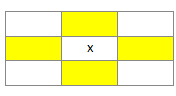

Ещё одна вспомогательная функция. С её помощью получаем значения соседних для текущего элемента ячеек. 

In [22]:
def neighbours(matrix, rowNumber, colNumber):
    result = []
    for rowAdd in range(-1, 2):
        newRow = rowNumber + rowAdd
        if newRow >= 0 and newRow <= matrix.shape[0]-1:
          if newRow == rowNumber:
            continue
          result.append(matrix[newRow][colNumber])
    for colAdd in range(-1, 2):
        newCol = colNumber + colAdd
        if newCol >= 0 and newCol <= matrix.shape[1]-1:
          if newCol == colNumber:
            continue
          result.append(matrix[rowNumber][newCol])
    return result

### Функция для определения бассейнов и линии водораздела:

Основная функция. Алгоритм реализован по описанию комбинированного подхода построения структурных линий изображения (раздел 6 статьи "Структурные линии и критические точки цифровых изображений"):

1. Отмечаем первый бассейн с наименьшим значением номером 0;
2. Двигаемся по пикселям изображения, отмечая новыми номерами бассейна пиксели с наименьшими значениями если рядом нет бассейна с таким же значением.
3. Если есть соседний пиксель с тем же значением, у которого уже есть номер бассейна, то даём текущему пикселю тот же номер бассейна.
4. Если пиксель находится между бассейнами, то присваиваем ему номер "-1" и он считается линией водораздела данного изображения.

Функция выводит "карту" изображения с отмеченными бассейнами и линиями водораздела, массив с информацией по каждому бассейну, который может пригодиться для того, чтобы восстановить исходное изображение.

In [23]:
def topo(image, sorted_arr):
  
  image_map = np.full(
  shape=image.shape,
  fill_value=None)
  
  basin_num = []
  basin_num.append(0)
  
  basin_val = []
  basin_val.append(image[sorted_arr[0][0]][sorted_arr[0][1]])
  
  basin_coord = []
  basin_coord.append(sorted_arr[0])

  image_map[sorted_arr[0][0]][sorted_arr[0][1]] = 0

  for pixel in sorted_arr[1:]:
    if all(neighb_pixel == None for neighb_pixel in neighbours(image_map, pixel[0], pixel[1])):
      image_map[pixel[0]][pixel[1]] = max(basin_num)+1
      basin_num.append(max(basin_num)+1)
      basin_val.append(image[pixel[0]][pixel[1]])
      basin_coord.append(pixel)

  for pixel in sorted_arr:
    if len(set(map(lambda x: x, filter(lambda x: x != None, neighbours(image_map, pixel[0], pixel[1]))))) == 1 and any(image[pixel[0]][pixel[1]] == pixval for pixval in neighbours(image_map, pixel[0], pixel[1])):
      image_map[pixel[0]][pixel[1]] = max(x for x in neighbours(image_map, pixel[0], pixel[1] )if x is not None)

  for pixel in sorted_arr:
    if len(set(map(lambda x: x, filter(lambda x: x != None, neighbours(image_map, pixel[0], pixel[1]))))) > 1:
      image_map[pixel[0]][pixel[1]] = -1
      
  for pixel in sorted_arr:
    if image_map[pixel[0]][pixel[1]] == None:
      image_map[pixel[0]][pixel[1]] = -1


  zipped = list(zip(basin_num, basin_val, basin_coord))
  df = pd.DataFrame(zipped, columns=['basin_num', 'basin_val', 'basin_coord'])

  return image_map, df

## Применение на примере

Ввод тестового массива значений размера 5х6:

/home/kaven/.local/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


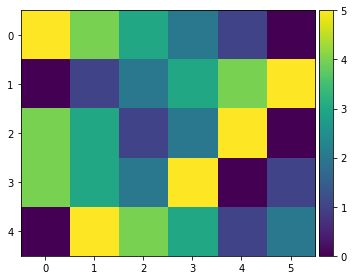

[[5 4 3 2 1 0]
 [0 1 2 3 4 5]
 [4 3 1 2 5 0]
 [4 3 2 5 0 1]
 [0 5 4 3 1 2]]


In [24]:
# Test array

arr = np.array([[5,4,3,2,1,0],[0,1,2,3,4,5],[4,3,1,2,5,0], [4,3,2,5,0,1],[0,5,4,3,1,2]])

io.imshow(arr)
plt.show()

print(arr)

Применим функцию topo к тестовому массиву:

In [25]:
rez = topo(arr, sort_by_values(arr))
print(rez)

(array([[-1, 10, -1, 6, -1, 0],
       [1, -1, -1, -1, 11, -1],
       [-1, -1, 5, -1, -1, 2],
       [-1, 8, -1, -1, 3, -1],
       [4, -1, -1, 9, -1, 7]], dtype=object),     basin_num  basin_val basin_coord
0           0          0      [0, 5]
1           1          0      [1, 0]
2           2          0      [2, 5]
3           3          0      [3, 4]
4           4          0      [4, 0]
5           5          1      [2, 2]
6           6          2      [0, 3]
7           7          2      [4, 5]
8           8          3      [3, 1]
9           9          3      [4, 3]
10         10          4      [0, 1]
11         11          4      [1, 4])


Построим получившийся рисунок структурных линий для тестового массива:

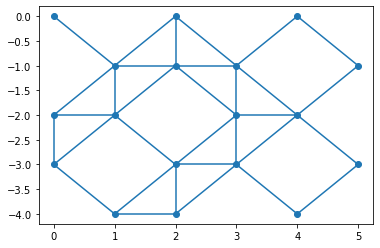

In [9]:
# Get coordinates of topo lines

lines_coord = np.argwhere(rez[0]==-1)

idx = np.vstack(np.triu_indices(len(lines_coord), k=1)).T
d = pdist(lines_coord)
t = lines_coord[idx[d<=np.sqrt(2)]]

for i in t:
    x = [-i[0][0], -i[1][0]]
    y = [i[0][1], i[1][1]]
    plt.plot(y,x, color='C0')

plt.scatter(lines_coord[:,1], -lines_coord[:,0]) # we have to change coord x and y between each other and reverse y in order to plot it with pyplot


Начал писать функцию для восстановления исходного изображения, пока только бассейны восстанавливаются.

In [26]:
# Restore image

def restore(topo_output):
  topo_image = topo_output[0]
  topo_df = topo_output[1]

  basin_num = topo_output[1]['basin_num']
  basin_val = topo_output[1]['basin_val']
  basin_coord = topo_output[1]['basin_coord']


  topo_lines = np.argwhere(topo_image[0]==-1)

  rest_image = np.full(
  shape=topo_image.shape,
  fill_value=None)

  # Restore basins
  for i in topo_df.index:
    rest_image[basin_coord.iloc[i][0]][basin_coord.iloc[i][1]] = basin_val.iloc[i]

  # Restore topo lines
  

  return print(rest_image)


In [27]:
restore(rez)

[[None 4 None 2 None 0]
 [0 None None None 4 None]
 [None None 1 None None 0]
 [None 3 None None 0 None]
 [0 None None 3 None 2]]


# На примере реального изображения

Загрузка изображения:

In [29]:
# Read image
im = iio.imread('test.jpg')

/tmp/ipykernel_870/4270037344.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = iio.imread('test.jpg')


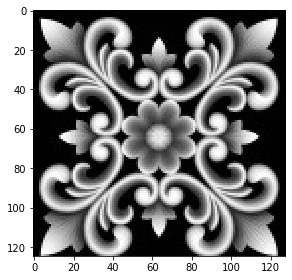

In [30]:
# Print imported image
io.imshow(im[:,:,0])
plt.show()

In [31]:
img = im[:,:,0]

srt_ind = sort_by_values(img)

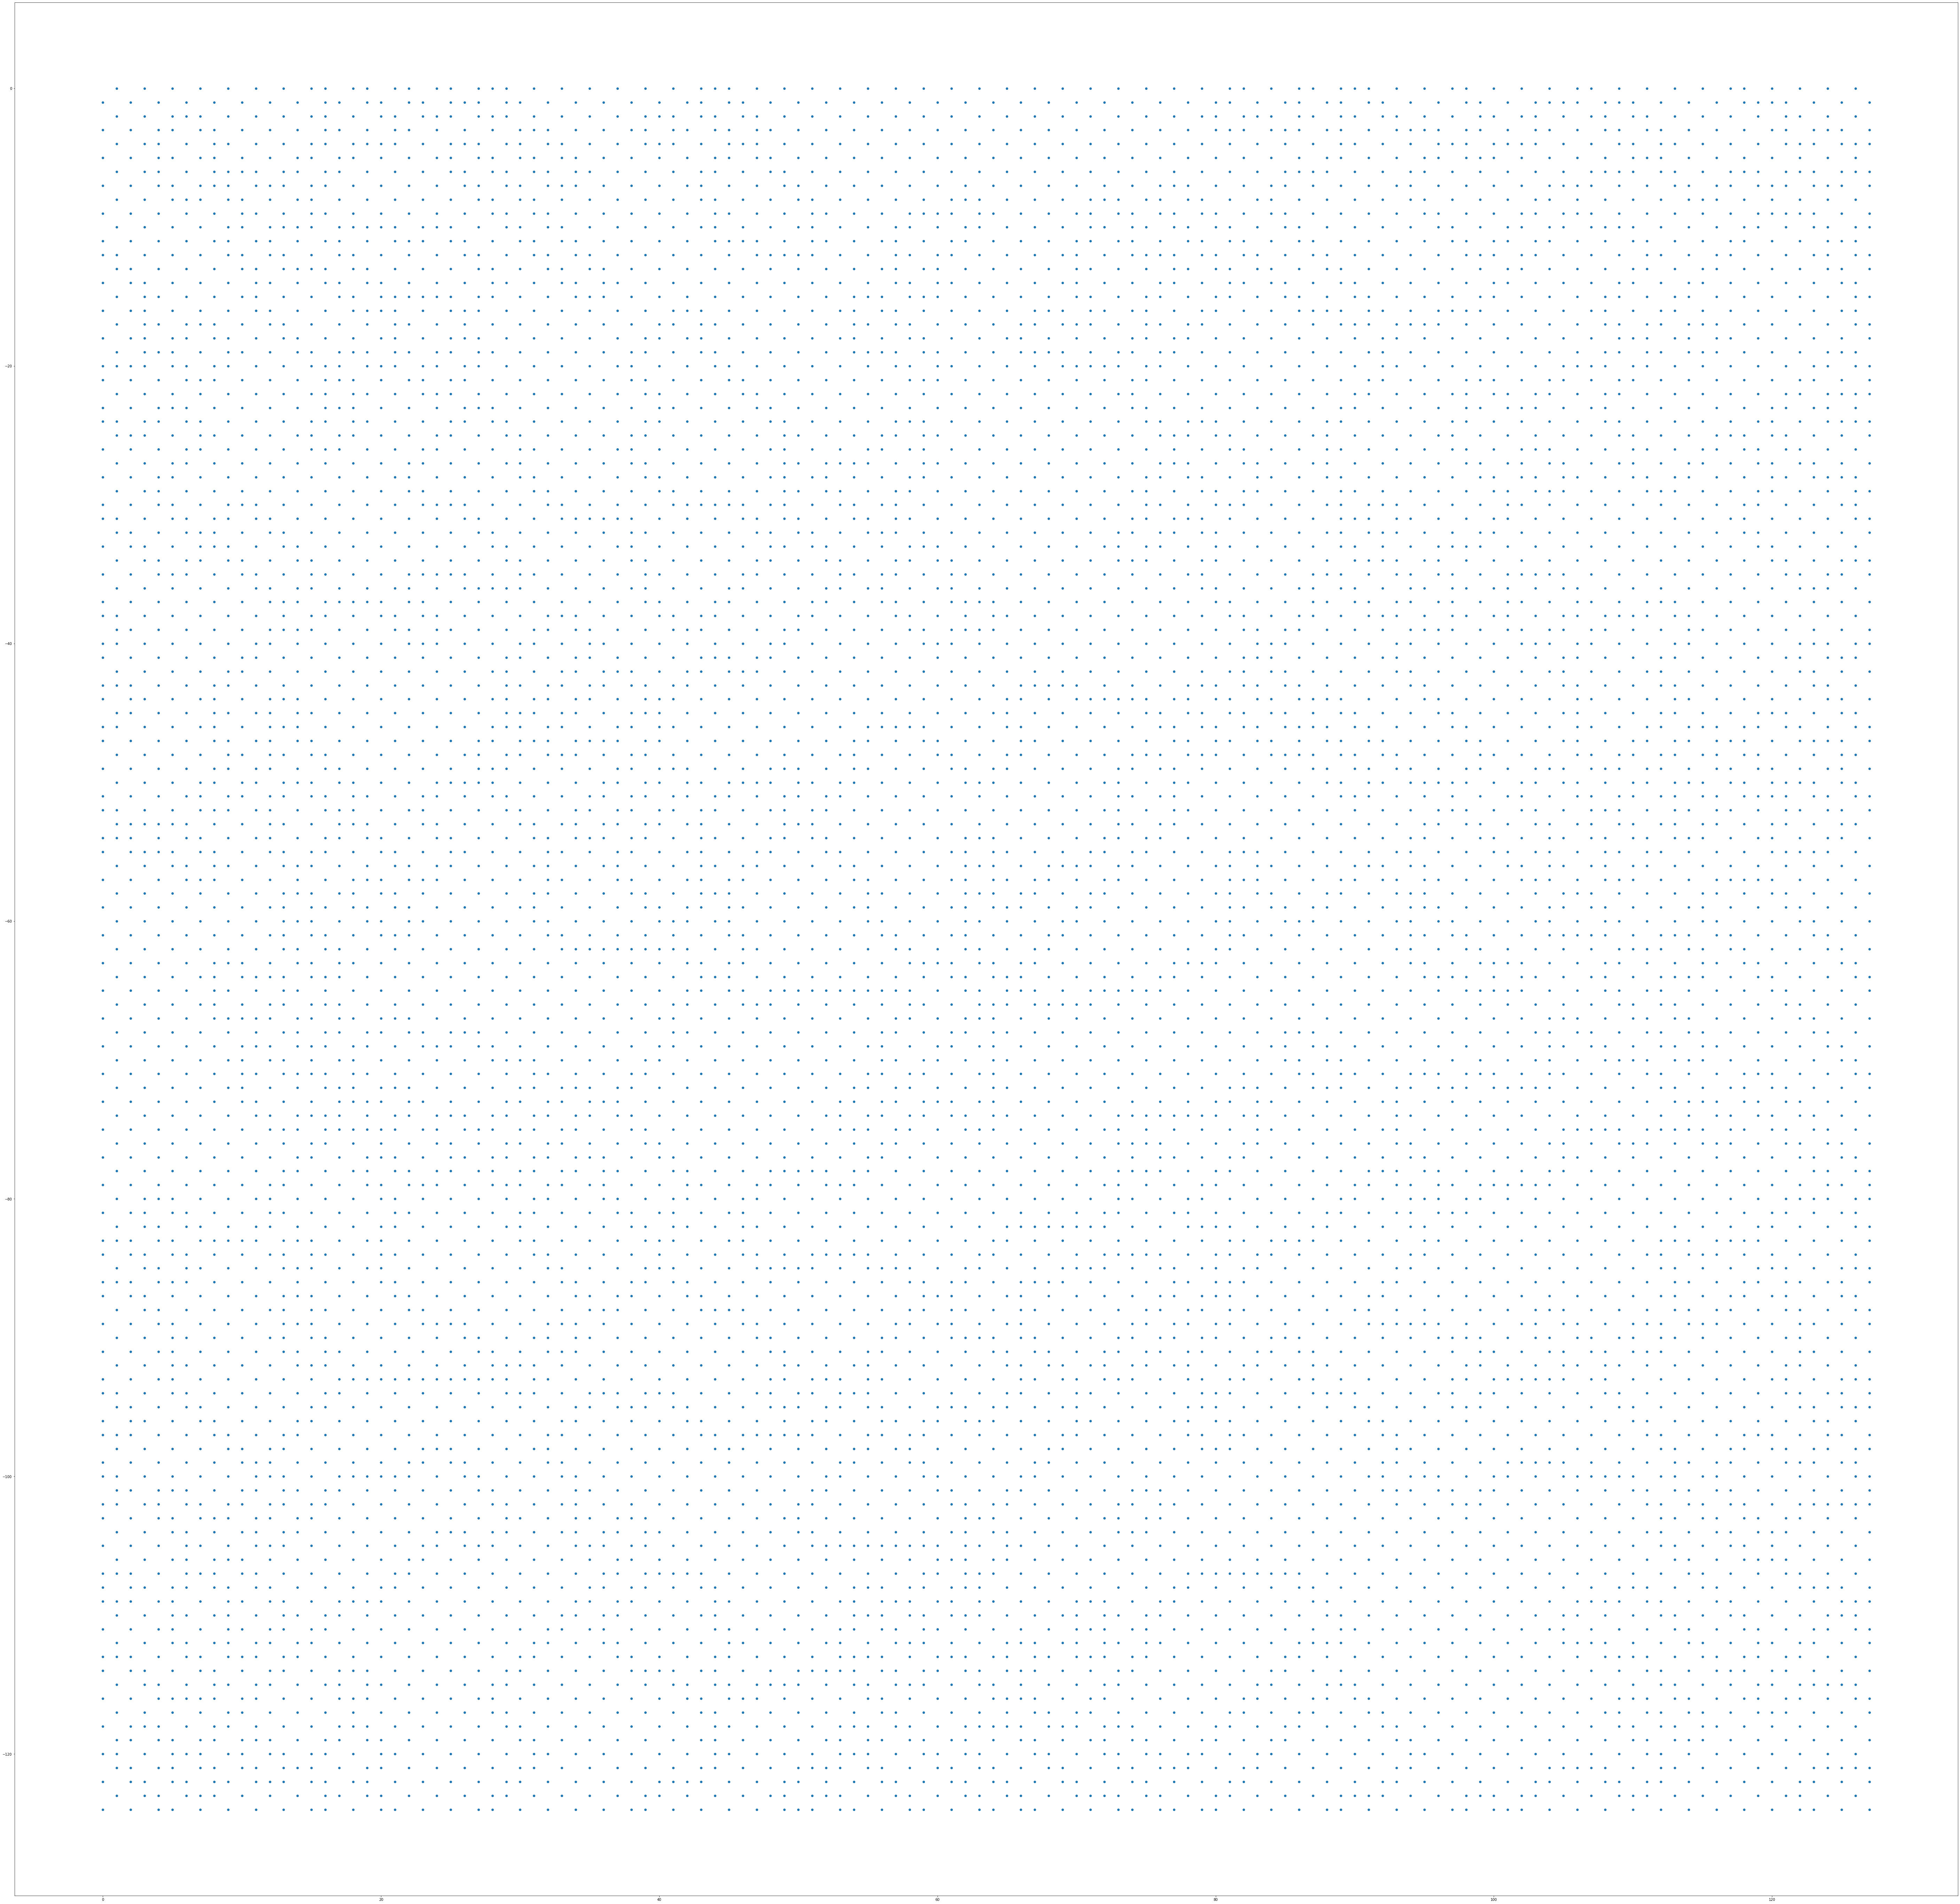

In [32]:
test = topo(img, srt_ind)
lines_coord = np.argwhere(test[0]==-1)

plt.figure(figsize=(100,100))
plt.scatter(lines_coord[:,1], -lines_coord[:,0]) # we have to change coord x and y between each other and reverse y in order to plot it with pyplot

In [33]:
idx = np.vstack(np.triu_indices(len(lines_coord), k=1)).T
d = pdist(lines_coord)
t = lines_coord[idx[d<=np.sqrt(2)]]

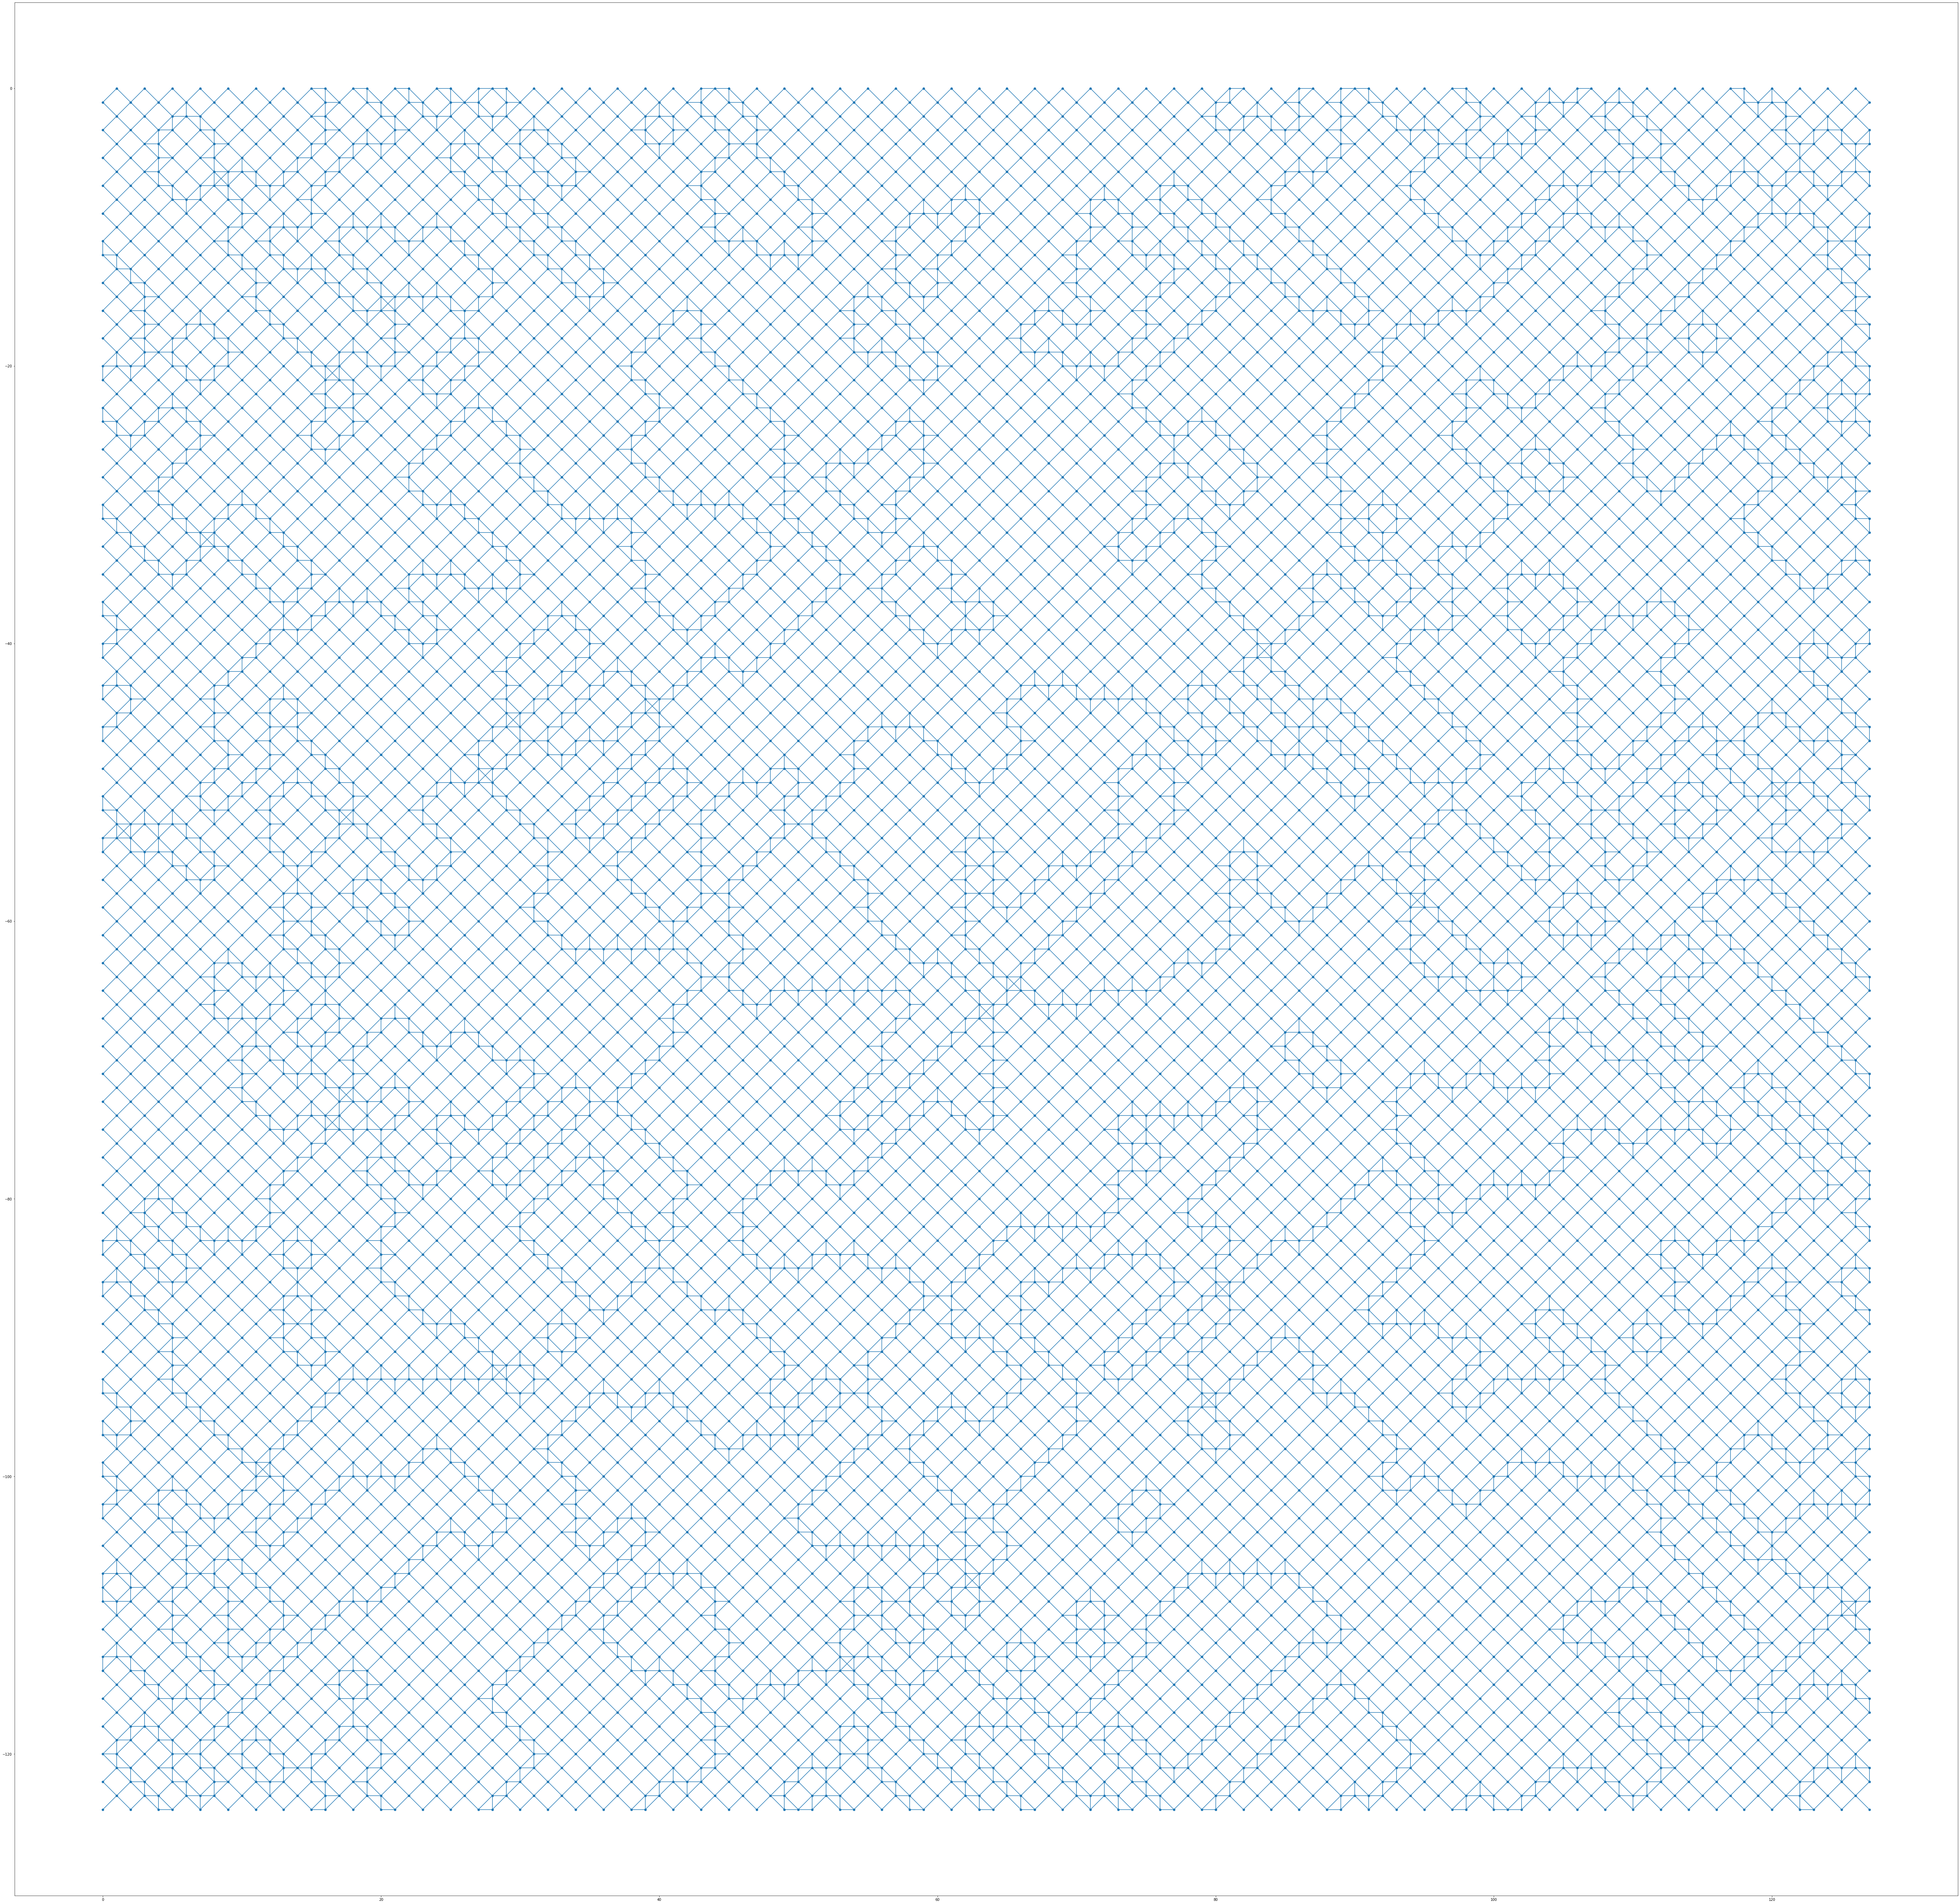

In [34]:

plt.figure(figsize=(100,100))
for i in t:
    x = [-i[0][0], -i[1][0]]
    y = [i[0][1], i[1][1]]
    plt.plot(y,x, color='C0')
plt.scatter(lines_coord[:,1], -lines_coord[:,0]) # we have to change coord x and y between each other and reverse y in order to plot it with pyplot